# TD 4 - Topological Persistence


*by Joseph DE ROFFIGNAC and Ten NGUYEN HANAOKA* 

The purpose of this notebook is to address all the exercises from Lab Session 4 (INF556 – TD4), which focuses on implementing an algorithm to compute persistent homology with coefficients in the field ℤ/2ℤ (also denoted ℤ₂), and on testing it across various filtrations.

### Let's start with some imports !

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import read_filtration, plot_barcodes

We are provided with a Simplex class (see simplex.py for more details) that contains three attributes:
* val (float): the time of appearance in the filtration,
* dim (int): the dimension,
* vert (list[int]): the list of vertex IDs (integers).

In addition, a read_filtration function in utils.py is available, which takes a filename (str) as input and returns a filtration represented as a list of simplices.

An example of how to use read_filtration is given just below :

In [5]:
filtration = read_filtration("filtrations/filtration_test.txt")
for simplex in filtration:
    print(simplex)
type(filtration[0])

{'time': 1.0, 'dim': 0, 'vert': {2}}
{'time': 1.0, 'dim': 0, 'vert': {4}}
{'time': 1.0, 'dim': 0, 'vert': {1}}
{'time': 2.0, 'dim': 1, 'vert': {2, 4}}
{'time': 2.0, 'dim': 1, 'vert': {1, 2}}
{'time': 3.0, 'dim': 0, 'vert': {7}}
{'time': 4.0, 'dim': 1, 'vert': {4, 7}}
{'time': 4.0, 'dim': 1, 'vert': {1, 7}}
{'time': 5.0, 'dim': 1, 'vert': {1, 4}}
{'time': 6.0, 'dim': 2, 'vert': {1, 4, 7}}


dict

To simplify our process, we've added a line in read_filtration, that outputs a time sorted filtration

## Question 1 - Boundary matrix

**Question 1**:Compute the boundary matrix B of the filtration from the vector of simplices F. 

In [6]:
def boundary_matrix(filtration: list[dict]) -> list[list[int]]:
    
    # Dictionnaire : clé = frozenset(vertices), valeur = index dans la filtration
    index_map = {frozenset(s["vert"]): i for i, s in enumerate(filtration)}

    n = len(filtration)
    boundary = [set() for _ in range(n)]

    for j, simplex in tqdm(enumerate(filtration), desc="Computing boundary matrix", total=n):
        verts = simplex["vert"]
        dim = simplex["dim"]

        # Génération des faces en retirant un sommet
        if dim > 0:
            for v in verts:
                face = frozenset(verts - {v})
                i = index_map.get(face)
                if i is not None:
                    boundary[j].add(i)

    return boundary

print(boundary_matrix(filtration))

Computing boundary matrix: 100%|██████████| 10/10 [00:00<00:00, 104077.02it/s]

[set(), set(), set(), {0, 1}, {0, 2}, set(), {1, 5}, {2, 5}, {1, 2}, {8, 6, 7}]


## Questions 2 & 3 - Reduction algorithm

**Question 2**  : Implement the reduction algorithm for your representation of the boundary matrix. Evaluate its complexity.

In [7]:
def reduce_boundary_matrix(boundary : list[set[int]]) -> list[set[int]]:
    
    reduced_boundary = boundary.copy()
    m = len(reduced_boundary)

    pivots = {}

    for j in tqdm(range(m), desc="Reducing boundary matrix"):

        low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        while low_j != -1 and low_j in pivots:

            i = pivots[low_j]

            # Perform column addition (mod 2) : XOR
            reduced_boundary[j] = set(reduced_boundary[j]) ^ set(reduced_boundary[i])
            low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        if low_j != -1:
            pivots[low_j] = j

    return reduced_boundary


**Question 3** Reduce the complexity of the reduction to O(m^3) in the worst case, and to O(m) in cases where the matrix remains sparse throughout, where m is the number of simplices in the filtration. Argue that your code does have the desired worst-case and best-case complexities.

#TODO Il faudra écrire la démo de notre complexité ici (en particulier justifier que low_j est bien un monovariant de notre boucle while)

## Question 4 - Barcode extraction

In [8]:
def extract_barcodes(reduced_boundary: list[list[int]], filtration: list[dict]) -> list[tuple[int, int, int]]:
    barcodes = []
    paired = set()

    for j, col in enumerate(reduced_boundary):
        if col:
            low_j = max(col)  # sorted list: last element = pivot
            barcodes.append((filtration[low_j]["dim"], low_j, j))  # (dimension, birth, death)
            paired.add(low_j)
            paired.add(j)

    # Infinite bars: unpaired simplices
    for i, f in enumerate(filtration):
        if i not in paired:
            barcodes.append((f["dim"], i, -1))  # death = ∞

    # Sort by (dimension, birth index, death index)
    barcodes.sort(key=lambda x: (x[0], x[1], x[2] if x[2] != -1 else float('inf')))

    # Convert bars to (dimension, birth time, death time)
    barcodes = [(dim, filtration[birth_idx]["time"], filtration[death_idx]["time"] if death_idx != -1 else float('inf'))
                for dim, birth_idx, death_idx in barcodes]
    return barcodes


In [9]:
def print_barcodes(barcodes: list[tuple[int, int, int]]) -> None:
    for dim, birth, death in barcodes:
        print(f"Dimension: {dim}, Birth: {birth}, Death: {death}")

## Question 5 - Complexity analysis

Filtration initialized.


Computing boundary matrix: 100%|██████████| 54/54 [00:00<00:00, 295296.50it/s]


Boundary matrix computed.


Reducing boundary matrix: 100%|██████████| 54/54 [00:00<00:00, 383235.90it/s]

Barcodes extracted.
Dimension: 0, Birth: 0.0, Death: inf
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 0, Birth: 0.0, Death: 1.0
Dimension: 1, Birth: 1.0, Death: inf
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: inf
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birth: 1.0, Death: 2.0
Dimension: 1, Birt

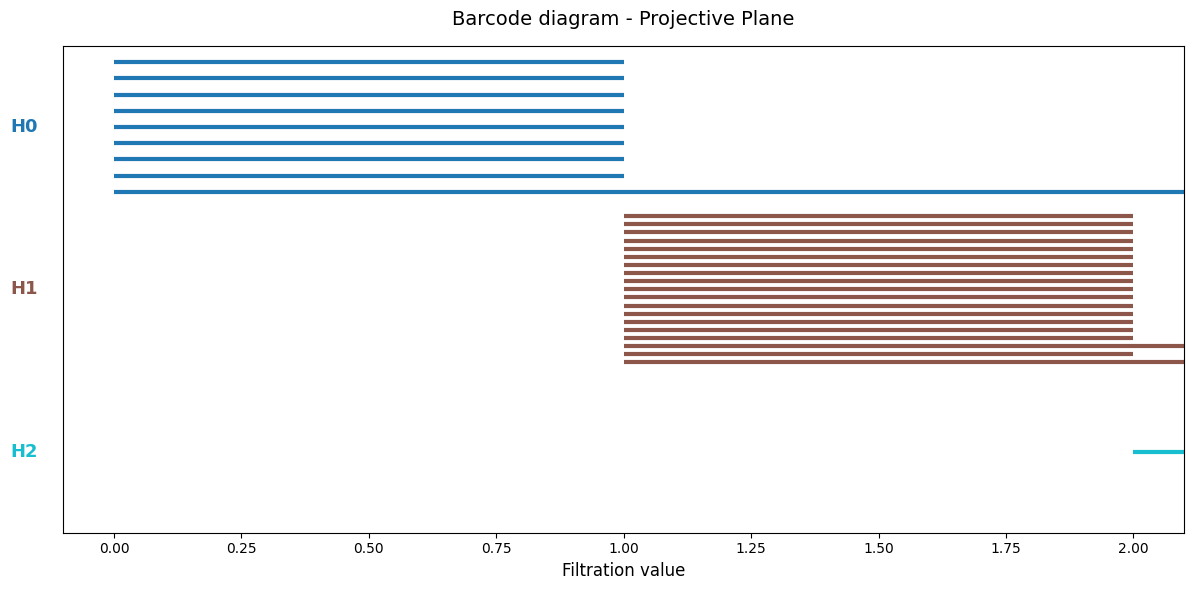

In [16]:
## Question 5 - Complexity analysis
filtration_a = read_filtration("filtrations/filtration_klein_bottle.txt")
print("Filtration initialized.")
B = boundary_matrix(filtration_a)
print("Boundary matrix computed.")
barcodes = extract_barcodes(reduce_boundary_matrix(B), filtration_a)
print("Barcodes extracted.")
print_barcodes(barcodes)
plot_barcodes(barcodes, name="Projective Plane")

## TODO list


In [11]:
# TODO : report, answer questions, complexity analysis, plots, analysis of graphs, 2 3 pages. 
# >>> jupyter notebook
# utils bar code + BDSD + représentation graphique + tableau des temps

Filtration initialization


Computing boundary matrix: 100%|██████████| 55/55 [00:00<00:00, 462298.04it/s]


Boundary matrix computed.


Reducing boundary matrix: 100%|██████████| 55/55 [00:00<00:00, 317750.30it/s]


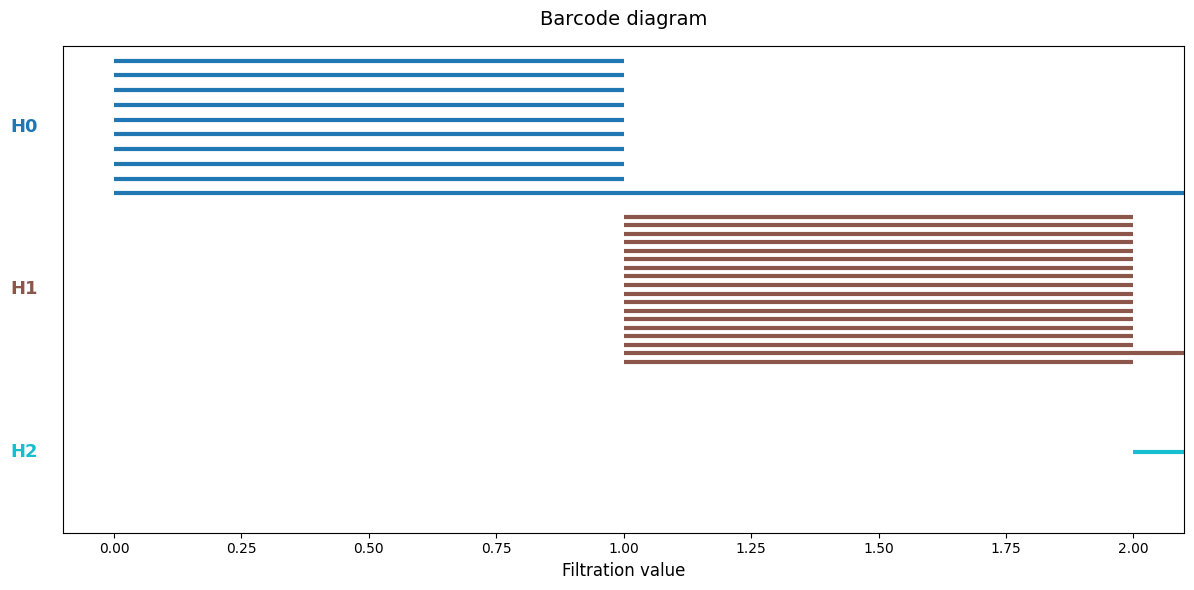

In [12]:
from itertools import combinations

def create_filtration(shape = "ball", dim = 10):
    # énumérer les parties d'une liste de points
    if shape == "ball":
        points = list(range(dim + 1))
    elif shape == "sphere":
        points = list(range(dim + 2))
    else:
        raise Exception("Shape should be \"ball\" or \"sphere\"")

    filtration = []
    for r in range(1, dim+1):
        for comb in combinations(points, r):
            filtration.append({"vert": set(comb), "dim": r - 1, "time": r})

    return filtration


filtration_a = read_filtration("filtrations/filtration_projective_plane.txt")
print("Filtration initialization")
B = boundary_matrix(filtration_a)
print("Boundary matrix computed.")
plot_barcodes(extract_barcodes(reduce_boundary_matrix(B), filtration_a))